# Wine Quality Regression practice

## Dataset

https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009


### Context 

This datasets is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

Tips

What might be an interesting thing to do, is aside from using regression modelling, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'.
This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value.
Without doing any kind of feature engineering or overfitting you should be able to get an AUC of .88 (without even using random forest algorithm)

KNIME is a great tool (GUI) that can be used for this.

1 - File Reader (for csv) to linear correlation node and to interactive histogram for basic EDA.

2- File Reader to 'Rule Engine Node' to turn the 10 point scale to dichtome variable (good wine and rest), the code to put in the rule engine is something like this:

$quality$ > 6.5 => "good"
TRUE => "bad" 

3- Rule Engine Node output to input of Column Filter node to filter out your original 10point feature (this prevent leaking)

4- Column Filter Node output to input of Partitioning Node (your standard train/tes split, e.g. 75%/25%, choose 'random' or 'stratified')

5- Partitioning Node train data split output to input of Train data split to input Decision Tree Learner node and 

6- Partitioning Node test data split output to input Decision Tree predictor Node

7- Decision Tree learner Node output to input Decision Tree Node input

8- Decision Tree output to input ROC Node.. (here you can evaluate your model base on AUC value)



In [1]:
import pandas as pd
import explore
import feature_engineering
import split_scale
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from math import sqrt
from scipy import stats
from pydataset import data
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression

from sklearn.metrics import explained_variance_score

import seaborn as sns
import evaluate
import sklearn.metrics

In [2]:
wines = pd.read_csv("wine-quality-red.csv")

In [3]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Lucky, it seems there are no null values. Since the data comes from Kaggle, I will trust that it is clean data for now. 

In [4]:
wines["quality_bins"] = pd.cut(wines.quality, 3, labels=["low", "medium", "high"])

## Split and Scale 

In [5]:
train, test = split_scale.split_my_df(wines)

In [6]:
X_train = train.drop(columns=["quality", "quality_bins"])
y_train = train[["quality"]]
X_test = test.drop(columns=["quality", "quality_bins"])
y_test = test[["quality"]]

In [7]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_bins
1076,9.9,0.32,0.56,2.0,0.073,3.0,8.0,0.99534,3.15,0.73,11.4,6,medium
847,7.4,0.68,0.16,1.8,0.078,12.0,39.0,0.99770,3.50,0.70,9.9,6,medium
582,11.7,0.49,0.49,2.2,0.083,5.0,15.0,1.00000,3.19,0.43,9.2,5,medium
172,8.0,0.42,0.17,2.0,0.073,6.0,18.0,0.99720,3.29,0.61,9.2,6,medium
779,7.1,0.52,0.03,2.6,0.076,21.0,92.0,0.99745,3.50,0.60,9.8,5,medium


## Explore

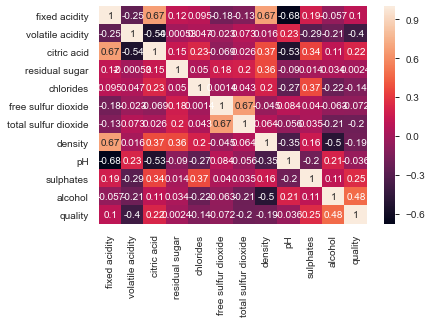

In [8]:
sns.heatmap(train.corr(), annot=True)

At this point, we notice that there are no variables that are highly correlated with our target variable. `alcohol` and `volatile acidity` seem to have the highest correlation. Luckuly, those two variables also don't seem to be too correlated with each other. 

In [9]:
train.corr().quality.sort_values()

volatile acidity       -0.399479
total sulfur dioxide   -0.201756
density                -0.186942
chlorides              -0.137099
free sulfur dioxide    -0.072373
pH                     -0.035631
residual sugar          0.002350
fixed acidity           0.104519
citric acid             0.221081
sulphates               0.251701
alcohol                 0.479006
quality                 1.000000
Name: quality, dtype: float64

In [10]:
train.quality.describe()

count    1279.000000
mean        5.631744
std         0.805668
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

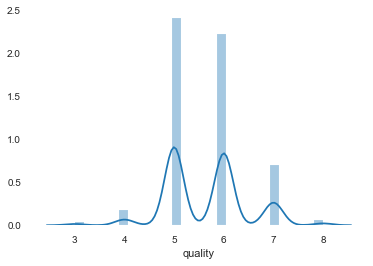

In [25]:
sns.distplot(train.quality)

The data is fairly normally distributed - it seems that the majority of the values are between 5 and 6. 

In [30]:
print(f'''

The difference between the mean {wines.quality.mean():.2f} and median {wines.quality.median():.2f} is: 

{wines.quality.mean() - wines.quality.median():.2f}

This also supports the fact that the data is normally distributed.
 
''')



The difference between the mean 5.64 and median 6.00 is: 

-0.36

This also supports the fact that the data is normally distributed.
 



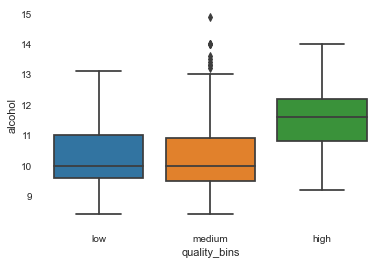

In [11]:
sns.boxplot(x="quality_bins", y="alcohol", data=wines)

When we bin the values, and try to look at the alcohol distribution per quality bin, we actually see that there isn't as much of a difference, although higher quality wines are, on average, much higher alcohol content. An interesting observation is the fact that there are plently of outliers in the medium bin. This tells me that acohol alone is not enough of an indicator of quality.

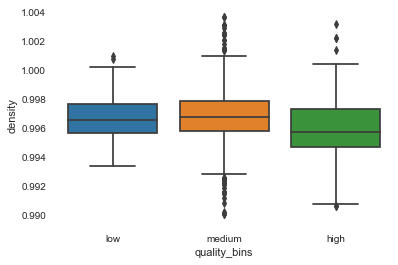

In [12]:
sns.boxplot(x= "quality_bins", y = "density", data = wines)

Density also has a high correlation, but in reality, it seems that there is not much difference in mean. At the same time there are a lot of outliers, which leads me to believe that the data is a bit skewed. Even though there is a negative correlation between these values, it doesn't seem to show too much in the bins.

In [13]:
scaler, train_scaled, test_scaled = split_scale.min_max_scaler(X_train, X_test)

## Feature Selection

In [31]:
feature_engineering.rfe(X_train, y_train,3)

3 selected features
['volatile acidity', 'chlorides', 'density']


## Modeling

In [15]:
assert(X_train.shape[0]) == y_train.shape[0]

In [16]:
predictions = pd.DataFrame({'actual': y_train.quality})
predictions["baseline"] = y_train.quality.mean()

In [32]:
# Using RFE Suggestions

X_1 = train_scaled[["volatile acidity", "density", "chlorides"]]
y_1 = y_train

lm = LinearRegression().fit(X_1, y_1)
predictions["density_volatile_acidity"] = lm.predict(X_1)

In [18]:
# Using all features

X_2 = train_scaled
y_2 = y_train

lm = LinearRegression().fit(X_2, y_2)

predictions["all_features"] = lm.predict(X_2)

In [33]:
predictions.head()

,actual,baseline,density_volatile_acidity,all_features
1076,6,5.631744,6.112384,6.377429
847,6,5.631744,5.307547,5.304216
582,5,5.631744,5.474990,5.236251
172,6,5.631744,5.807063,5.486579
779,5,5.631744,5.609400,5.245140


In [34]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual, col))

actual                      0.000000
baseline                    0.648594
density_volatile_acidity    0.519386
all_features                0.413551
dtype: float64

In [35]:
print(f'''
Evaluate all key features: 

MSE = {sklearn.metrics.mean_squared_error(predictions.actual, predictions.all_features):.2}

RMSE = {sqrt(sklearn.metrics.mean_squared_error(predictions.actual, predictions.all_features)):.2}

R-square = {explained_variance_score(predictions.actual, predictions.all_features):.2f}
'''
)


Evaluate all key features: 

MSE = 0.41

RMSE = 0.64

R-square = 0.36

